# **Proyek Kedua : Membuat Model Machine Learning dengan Data Time Series**
### Nama : Thariq Iskandar Zulkarnain M P
### No. Pendaftaran : 0182180151-57
### Email : thariqiskandar9@gmail.com
### No. Handphone : 6281332409623
### Tema Pelatihan : FGA Machine Learning (IBM)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
#membuat kelas callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < scale10 and logs.get('val_mae') < scale10):
      self.model.stop_training = True
      print("\nmodel memiliki mae dan val_mae < 10% dari skala data")
callbacks = myCallback()

In [3]:
#input dataset harga saham AABA dari tahun 2006 sampai 2018
df = pd.read_csv('AABA_2006-01-01_to_2018-01-01.csv')
df

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
1,2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA
2,2006-01-05,40.93,41.73,40.85,41.53,12829610,AABA
3,2006-01-06,42.88,43.57,42.80,43.21,29422828,AABA
4,2006-01-09,43.10,43.66,42.82,43.42,16268338,AABA
...,...,...,...,...,...,...,...
3014,2017-12-22,71.42,71.87,71.22,71.58,10979165,AABA
3015,2017-12-26,70.94,71.39,69.63,69.86,8542802,AABA
3016,2017-12-27,69.77,70.49,69.69,70.06,6345124,AABA
3017,2017-12-28,70.12,70.32,69.51,69.82,7556877,AABA


In [4]:
#meilhat apakah ada data yang hilang dari dataset
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

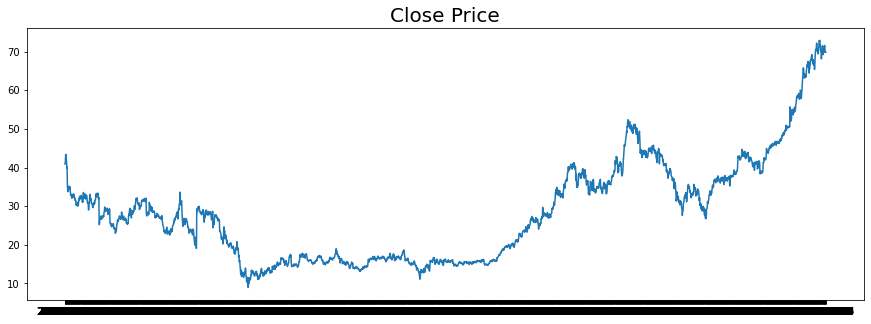

In [5]:
date = df['Date'].values
close  = df['Close'].values #pada kasus ini digunakan harga penutupan / close price
 
#membuat plot dari data 
plt.figure(figsize=(15,5))
plt.plot(date, close)
plt.title('Close Price',
          fontsize=20);

In [6]:
#membuat fungsi window
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
#split dataset dengan ratio 80:20
close_train, close_test, date_train, date_test = train_test_split(close, date, test_size = 0.2, random_state = 0 , shuffle=False)

In [8]:
#memanggil fungsi window untuk membagi data menjadi atribut dan label
data_close_train = windowed_dataset(close_train, window_size=60, batch_size=100, shuffle_buffer=5000)
data_close_test = windowed_dataset(close_test, window_size=60, batch_size=100, shuffle_buffer=5000)

In [9]:
#membangun arsitektur neural network
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [10]:
#menentukan batas nilai 10% dari skala data untuk parameter callback
scale10 = (close.max() - close.min()) * (10 / 100)
print(scale10)

6.398000000000001


In [11]:
#menggunakan parameter learning rate dan momentum pada optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)

#melakukan compile pada model
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

#latih model dengan jumlah epoch 100
history = model.fit(data_close_train,
                    epochs=100, 
                    validation_data=data_close_test, 
                    callbacks=[callbacks])

Epoch 1/100
24/24 [==============================] - 8s 172ms/step - loss: 23.5296 - mae: 24.0296 - val_loss: 45.4327 - val_mae: 45.9327
Epoch 2/100
24/24 [==============================] - 3s 112ms/step - loss: 23.4612 - mae: 23.9612 - val_loss: 45.3602 - val_mae: 45.8602
Epoch 3/100
24/24 [==============================] - 3s 112ms/step - loss: 23.3794 - mae: 23.8794 - val_loss: 45.2569 - val_mae: 45.7569
Epoch 4/100
24/24 [==============================] - 3s 110ms/step - loss: 23.2713 - mae: 23.7713 - val_loss: 45.1428 - val_mae: 45.6428
Epoch 5/100
24/24 [==============================] - 3s 110ms/step - loss: 23.1448 - mae: 23.6448 - val_loss: 45.0035 - val_mae: 45.5035
Epoch 6/100
24/24 [==============================] - 3s 110ms/step - loss: 22.9844 - mae: 23.4844 - val_loss: 44.8200 - val_mae: 45.3200
Epoch 7/100
24/24 [==============================] - 3s 109ms/step - loss: 22.7738 - mae: 23.2738 - val_loss: 44.5741 - val_mae: 45.0741
Epoch 8/100
24/24 [======================

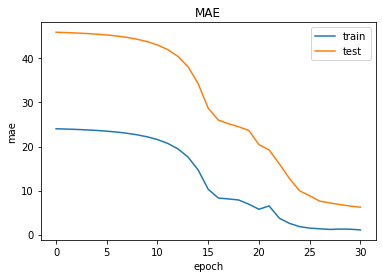

In [12]:
#plot dari mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

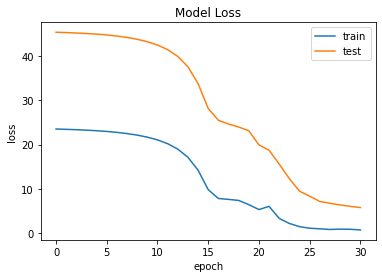

In [13]:
#plot dari loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()